In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

torch.manual_seed(1)

We try to predict the quality of red wine, given 11 features.  
To do so, we contrast 3 different ML pipelines.
- Fitting a NN on the original features of the data.
- Using PCA to reduce the dimensionality of the feature space, then fitting a model on the principle components.
- First training an AE, then fit a model using on the latent space of the AE.

Before we do so, we first create a training, validation and test set and dataloader.

In [2]:
data = pd.read_csv("winequality-red.csv")
data = data.astype('float32')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0


In [3]:
n = len(data)
train = int(n * 0.8)
val = int(n * 0.1)

#normalize, using only the stats of the training set, to avoid information about the 
#val and test sets to leak.
train_set = data[:train]
data = (data-train_set.mean())/train_set.std()

train_set = data[:train]
val_set = data[train + 1 : train + val]
test_set = data[train + val:]

In [4]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __getitem__(self, index):
        row = self.dataframe.iloc[index].to_numpy()
        features = row[:-1]
        label = row[-1]
        return features, label

    def __len__(self):
        return len(self.dataframe)

#instantiate dataloaders
train_data = CustomDataset(dataframe = train_set)
train_loader = DataLoader(train_data, batch_size = 32)

val_data = CustomDataset(dataframe = val_set)
val_loader = DataLoader(val_data, batch_size = 32)

test_data = CustomDataset(dataframe = test_set)
test_loader = DataLoader(test_data, batch_size = 32)

#loss
loss_fn = nn.L1Loss(reduction = 'mean')

In [37]:
def train_step(model, optimizer, dataloader, loss_fn):
    model.train()
    losses = []
    for x,y in dataloader:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())
        
    return sum(losses)/len(losses)

def evaluate(model, dataloader, loss_fn):
    with torch.no_grad():
        model.eval()
        losses = []
        for x,y in dataloader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y.unsqueeze(1))
            losses.append(loss.detach())
            
    return sum(losses)/len(losses)

def train(model, optimizer, epochs, train_dataloader, val_dataloader, loss_fn):
    train_loss, val_loss = [], []
    for i in range(epochs):
        #training
        new_loss = train_step(model, optimizer, train_dataloader, loss_fn)
        train_loss.append(new_loss)
        #evaluating
        new_loss = evaluate(model, val_dataloader, loss_fn)
        val_loss.append(new_loss)
        
    return train_loss, val_loss

# First model
Fit directly on the input data

In [6]:
class first_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff1 = nn.Linear(11, 30)
        self.ff2 = nn.Linear(30, 25)
        self.ff3 = nn.Linear(25, 12)
        self.ff4 = nn.Linear(12,1)

    def forward(self, x):
        x = F.relu(self.ff1(x))
        x = F.relu(self.ff2(x))
        x = F.relu(self.ff3(x))
        x = F.tanh(self.ff4(x))
        return x

model = first_model()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

c:\Users\1888r\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we can see overfitting starting to happen, as the training loss continues to decrease, while the validation loss increases.  
We stop the model after 400 epochs to avoid overfitting.

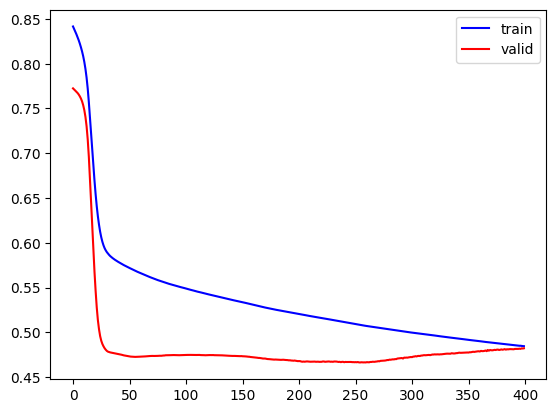

In [7]:
model = first_model()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

m1_train, m1_val = train(model, optimizer, 400, train_loader, val_loader, loss_fn)

plt.plot(range(400), m1_train, 'blue' , label = 'train')
plt.plot(range(400), m1_val, 'red' , label = 'valid')
plt.legend();

# Second approach: PCA model
We fit a PCA to the training set and use it to transform the features.

In [8]:
#first we separate the features from the target.
train_feat = train_set.iloc[:, :-1].to_numpy()
val_feat = val_set.iloc[:, :-1].to_numpy()
test_feat = test_set.iloc[:, :-1].to_numpy()

In [9]:
#fit PCA to the training data
pca = PCA(n_components = 7)
pca.fit(train_feat)

#Concatenate the transformed features with the target labels.
#the label dataframe is transformed to numpy array, then back to dataframe, so the indices are reset.
train_pca_df = pd.concat([pd.DataFrame(pca.transform(train_feat)), train_set.iloc[:, -1]], axis = 1)
val_pca_df = pd.concat([pd.DataFrame(pca.transform(val_feat)), pd.DataFrame(val_set.iloc[:, -1].to_numpy())], axis = 1)
test_pca_df = pd.concat([pd.DataFrame(pca.transform(test_feat)), pd.DataFrame(test_set.iloc[:, -1].to_numpy())], axis = 1)

In [10]:
train_pca = CustomDataset(dataframe = train_pca_df)
train_loader_pca = DataLoader(train_pca, batch_size = 32)

val_pca = CustomDataset(dataframe = val_pca_df)
val_loader_pca = DataLoader(val_pca, batch_size = 32)

test_pca = CustomDataset(dataframe = test_pca_df)
test_loader_pca = DataLoader(test_pca, batch_size = 32)

Now we are ready to create a model, similar to the one used in the first example

In [11]:
class pca_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff1 = nn.Linear(7, 30)
        self.ff2 = nn.Linear(30, 25)
        self.ff3 = nn.Linear(25, 12)
        self.ff4 = nn.Linear(12,1)

    def forward(self, x):
        x = F.relu(self.ff1(x))
        x = F.relu(self.ff2(x))
        x = F.relu(self.ff3(x))
        x = F.tanh(self.ff4(x))
        return x

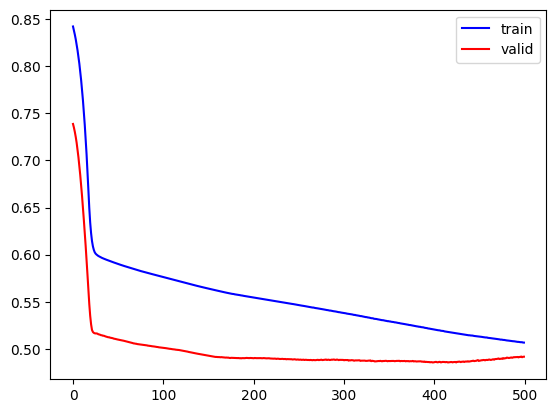

In [12]:
model_pca = pca_model()

optimizer = torch.optim.Adam(model_pca.parameters(), lr = 1e-4)
m2_train, m2_val = train(model_pca, optimizer, 500, train_loader_pca, val_loader_pca, loss_fn)

plt.plot(range(500), m2_train, 'blue' , label = 'train')
plt.plot(range(500), m2_val, 'red' , label = 'valid')
plt.legend();

# Third approach: AE model

In [27]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(nn.Linear(11, 15),
                                     nn.Tanh(),
                                     nn.LayerNorm(normalized_shape= 15),
                                     nn.Linear(15, 10),
                                     nn.Tanh(),
                                     nn.Linear(10, 7),
                                     nn.Tanh()
                                    )
        self.decode = nn.Sequential(nn.Linear(7, 10),
                                     nn.Tanh(),
                                     nn.LayerNorm(normalized_shape= 10),
                                     nn.Linear(10, 15),
                                     nn.Tanh(),
                                     nn.Linear(15, 11),
                                     nn.Tanh()
                                    )
        
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


In [40]:
def train_step_ae(model, optimizer, dataloader, loss_fn):
    model.train()
    losses = []
    for x,y in train_loader:
        optimizer.zero_grad()
        x_pred = model(x)
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())
        
    return sum(losses)/len(losses)

def evaluate_ae(model, dataloader, loss_fn):
    with torch.no_grad():
        model.eval()
        losses = []
        for x,y in dataloader:
            x_pred = model(x)
            loss = loss_fn(x_pred, x)
            losses.append(loss.detach())
            
    return sum(losses)/len(losses)

def train_ae(model, optimizer, epochs, train_loader, val_loader, loss_fn):
    train_loss, val_loss = [], []
    for i in range(epochs):
        #training
        new_loss = train_step_ae(model, optimizer, train_loader, loss_fn)
        train_loss.append(new_loss)
        #evaluating
        new_loss = evaluate_ae(model, val_loader, loss_fn)
        val_loss.append(new_loss)
        
    return train_loss, val_loss

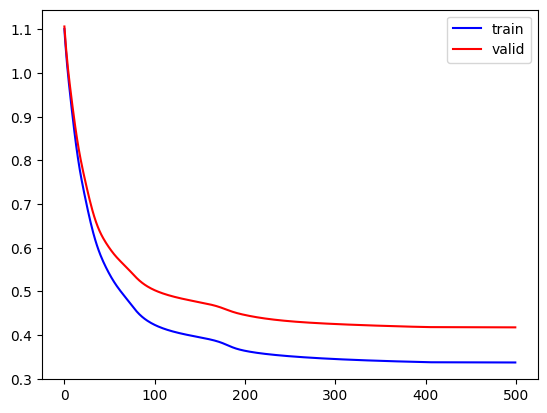

In [41]:
ae = AE()
loss_fn_ae = nn.MSELoss()

optimizer_ae = torch.optim.Adam(ae.parameters(), lr = 1e-4)
ae_train, ae_val = train_ae(ae, optimizer_ae, 400, train_loader, val_loader, loss_fn_ae)
#learning rate decay
optimizer_ae = torch.optim.Adam(ae.parameters(), lr = 1e-5)
ae_train2, ae_val2 = train_ae(ae, optimizer_ae, 100, train_loader, val_loader, loss_fn_ae)

plt.plot(range(500), ae_train + ae_train2, 'blue' , label = 'train')
plt.plot(range(500), ae_val + ae_val2, 'red' , label = 'valid')
plt.legend();

In [42]:
class Model_AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.ae = ae.encode
        self.ff1 = nn.Linear(7, 30)
        self.ff2 = nn.Linear(30, 25)
        self.ff3 = nn.Linear(25, 12)
        self.ff4 = nn.Linear(12,1)

    def forward(self, x):
        x = self.ae(x)
        x = F.relu(self.ff1(x))
        x = F.relu(self.ff2(x))
        x = F.relu(self.ff3(x))
        x = F.tanh(self.ff4(x))
        return x

First we initialize the model and freeze the encoder network.

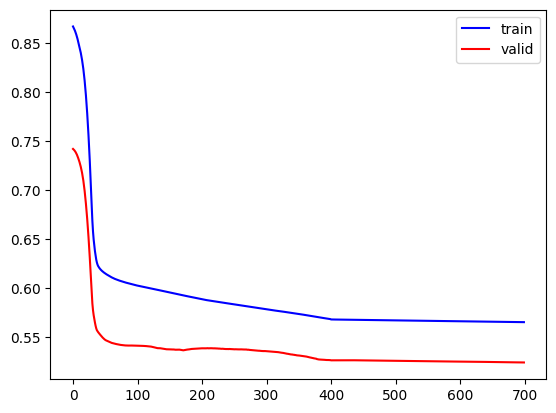

In [43]:
model_ae_frozen = Model_AE()

#freeze encoder network:
for param in model_ae_frozen.ae.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model_ae_frozen.parameters(), lr = 1e-4)
m3_train, m3_val = train(model_ae_frozen, optimizer, 400, train_loader, val_loader, loss_fn)

#lr decay
optimizer = torch.optim.Adam(model_ae_frozen.parameters(), lr = 1e-5)
m3_train2, m3_val2 = train(model_ae_frozen, optimizer, 300, train_loader, val_loader, loss_fn)

plt.plot(range(700), m3_train + m3_train2, 'blue' , label = 'train')
plt.plot(range(700), m3_val + m3_val2, 'red' , label = 'valid')
plt.legend();

We experiment with allowing the model to change the encoder network.

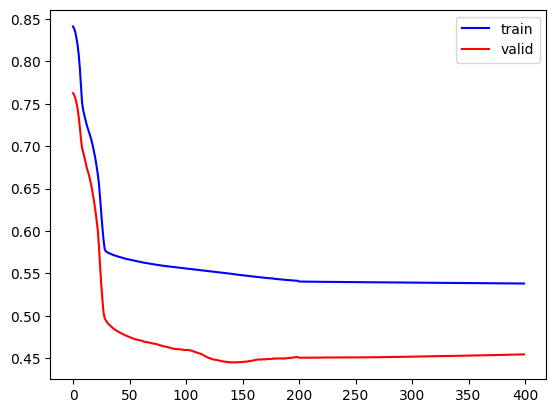

In [44]:
model_ae = Model_AE()
#unfreeze the parameters
for param in model_ae_frozen.ae.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model_ae.parameters(), lr = 1e-4)
m3_train, m3_val = train(model_ae, optimizer, 200, train_loader, val_loader, loss_fn)

#lr decay
optimizer = torch.optim.Adam(model_ae.parameters(), lr = 1e-5)
m3_train2, m3_val2 = train(model_ae, optimizer, 200, train_loader, val_loader, loss_fn)

plt.plot(range(400), m3_train + m3_train2, 'blue' , label = 'train')
plt.plot(range(400), m3_val + m3_val2, 'red' , label = 'valid')
plt.legend();

# Conclusion
We evaluate each of the models on the test set and print their respective losses, where lower is better. 

The first two models and the unfrozen ae models perform quite similarly.  
This is not surprising for the unfrozen AE model and the first model, considering that when the model is free to retrain the encoding block, it is essentially just a regular NN, with a similar architecture to the first model.  
The pca model performs slightly worse than the two with a test score of about $0.55$, but its performance is still very comparable to them.
This loss is quite good considering the loss of information that happend during the reduction from 11 input dimensions to 7.

By contrast, the AE model, where the encoder was frozen, performs considerably worse, achieving a test loss of $0.66$.
This was foreshadowed by the relatively high reconstruction loss of the AE network on the original data, which means that the AE was unfortunately not very good at learning a lower dimensional representation of the data.  
Given this distorted and lossy compression of the input data, the relatively high test loss of the AE model, with frozen encoder network, becomes understandable.  
It is interesting to see that on this dataset, PCA performed a lot better for data compression than our AE network.

We can also see how fast each model overfits from the training loss curves.  
The curse of dimensionality predicts that the models which are fitted on a higher dimensional input space, are more susceptible to overfitting.
This includes the first model, as well as the AE model, with encoding network unfrozen. 
And indeed we can observe this from the training loss curves.  
In contrast the PCA model and the AE model, in which the encoder network was frozen, only begin overfitting after the other two.  
The number of epochs on which each model was trained, was chosen so that we avoid both underfitting and overfitting on the data.

In [45]:
loss_fn = nn.L1Loss(reduction = 'mean')

m1_test = evaluate(model, test_loader, loss_fn)
m2_test = evaluate(model_pca, test_loader_pca, loss_fn)
m3_test = evaluate(model_ae, test_loader, loss_fn)
m4_test = evaluate(model_ae_frozen , test_loader, loss_fn)


print("Test scores for each of the models")
print(f"first model {m1_test:.4f} \npca model {m2_test:.4f} \nae model unfrozen {m3_test:.4f} \nae model frozen {m4_test:.4f}")

Test scores for each of the models
first model 0.5388 
pca model 0.5526 
ae model unfrozen 0.5119 
ae model frozen 0.6606
